In [1]:
import os
import sys
module_path = os.path.abspath('thinker/thinker')
if module_path not in sys.path:
    sys.path.append(module_path)

from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from collections import deque
import time
import numpy as np
import copy
import argparse
import torch
import torch.nn.functional as F
from thinker.env import Environment
from thinker.net import ActorNet, ModelNet
import gym
import thinker.util as util
%matplotlib inline

def plot_gym_env_out(x, ax=None, title=None):
    if ax is None: fig, ax = plt.subplots()
    ax.imshow(torch.swapaxes(torch.swapaxes(x[0,-3:].cpu(),0,2),0,1), interpolation='nearest', aspect="auto")
    if title is not None: ax.set_title(title)

def plot_multi_gym_env_out(xs, titles=None, col_n=5):
    size_n = 6
    row_n = (len(xs) + (col_n-1))// col_n
    
    fig, axs = plt.subplots(row_n, col_n, figsize=(col_n * size_n, row_n * size_n))  
    if(len(axs.shape) == 1): axs = axs[np.newaxis, :]
    m = 0
    for y in range(row_n):
        for x in range(col_n):
            if m >= len(xs): 
                axs[y][x].set_axis_off()
            else:
                axs[y][x].imshow(np.transpose(xs[m][-3:], axes=(1, 2, 0))/255)
                axs[y][x].set_title("rollout %d" % (m+1) if titles is None else titles[m])
            m += 1
    plt.tight_layout()
    return fig

def plot_policies(logits, labels, action_meanings, ax=None, title="Real policy prob"):
    if ax is None: fig, ax = plt.subplots()
    probs = []
    for logit, k in zip(logits, labels):
        if k != "action":
            probs.append(torch.softmax(logit, dim=-1).detach().cpu().numpy())
        else:
            probs.append(logit.detach().cpu().numpy())

    ax.set_title(title)
    xs = np.arange(len(probs[0]))    
    for n, (prob, label) in enumerate(zip(probs, labels)):
        ax.bar(xs + 0.1 * (n-len(logits) // 2), prob, width = 0.1, label=label)
    ax.xaxis.set_major_locator(mticker.FixedLocator(np.arange(len(probs[0]))))
    ax.set_xticklabels(action_meanings)
    ax.set_ylim(0, 1)        
    ax.legend()        

def plot_base_policies(logits, action_meanings, ax=None):
    if ax is None: fig, ax = plt.subplots()
    prob = torch.softmax(logits, dim=-1).detach().cpu().numpy()
    rec_t, num_actions = logits.shape
    xs = np.arange(rec_t)
    labels = action_meanings
    for i in range(num_actions):        
        c = ax.bar(xs + 0.8 * (i / num_actions), prob[:,i], width = 0.8 / (num_actions), label=labels[i])  
        color = c.patches[0].get_facecolor()
        color = color[:3] + (color[3] * 0.5,)
        ax.bar(xs + 0.8 * (i / num_actions), prob[:,i], width = 0.8 / (num_actions), color=color)
    ax.legend()
    ax.set_ylim(0, 1)   
    ax.set_title("Model policy prob")

def plot_im_policies(im_policy_logits, reset_policy_logits,  
                     im_action, reset_action, action_meanings,
                     one_hot=True, reset_ind=0, ax=None):
    if ax is None: fig, ax = plt.subplots()
        
    rec_t, num_actions = im_policy_logits.shape
    num_actions += 1
    rec_t -= 1
        
    im_prob = torch.softmax(im_policy_logits, dim=-1).detach().cpu().numpy()
    reset_prob = torch.softmax(reset_policy_logits, dim=-1)[:,[reset_ind]].detach().cpu().numpy()
    full_prob = np.concatenate([im_prob, reset_prob], axis=-1)
    
    if not one_hot: im_action = F.one_hot(im_action, num_actions - 1)
    im_action = im_action.detach().cpu().numpy()
    reset_action = reset_action.unsqueeze(-1).detach().cpu().numpy()    
    full_action = np.concatenate([im_action, reset_action], axis=-1)
    
    xs = np.arange(rec_t+1)
    labels = action_meanings.copy()
    labels.append('RESET')    
        
    for i in range(num_actions):        
        c = ax.bar(xs + 0.8 * (i / num_actions), full_prob[:,i], width = 0.8 / (num_actions), label=labels[i])  
        color = c.patches[0].get_facecolor()
        color = color[:3] + (color[3] * 0.5,)
        ax.bar(xs + 0.8 * (i / num_actions), full_action[:,i], width = 0.8 / (num_actions), color=color)
        
    ax.legend()
    ax.set_ylim(0, 1)   
    ax.set_title("Imagainary policy prob")    

def plot_qn_sa(q_s_a, n_s_a, action_meanings, max_q_s_a=None, ax=None):
    if ax is None: fig, ax = plt.subplots()
    xs = np.arange(len(q_s_a))

    ax.bar(xs - 0.3, q_s_a.cpu(), color = 'g', width = 0.3, label="q_s_a")    
    ax_n = ax.twinx()
    if max_q_s_a is not None:
        ax.bar(xs, max_q_s_a.cpu(), color = 'r', width = 0.3, label="max_q_s_a")        
    ax_n.bar(xs + (0.3 if max_q_s_a is not None else 0.), 
             n_s_a.cpu(), bottom=0, color = 'b', width = 0.3, label="n_s_a")
    ax.xaxis.set_major_locator(mticker.FixedLocator(np.arange(len(q_s_a))))
    ax.set_xticklabels(action_meanings)    
    ax.legend(loc="lower left")   
    ax_n.legend(loc="lower right") 
    ax.set_title("q_s_a and n_s_a")    

def print_im_actions(im_dict, action_meanings, print_stat=False):
    lookup_dict = {k:v for k, v in enumerate(action_meanings)}
    print_strs = []
    n, s = 1, ""
    reset = False
    for im, reset in zip(im_dict["im_action"][:-1], im_dict["reset_action"][:-1]):
        s += lookup_dict[im.item()] + ", "
        if reset:        
            s += "Reset"
            print_strs.append("%d: %s" %(n, s))
            s = ""
            n += 1
    if not reset: print_strs.append("%d: %s" %(n, s[:-2]))
    if print_stat: 
        for s in print_strs: print(s) 
    return print_strs    

In [7]:

# Visualize learned actor network

#check_point_path = '/media/sc/datadisk/data/thinker/logs/planner_logs/bootstrap_meanq_no_im_reward'
#check_point_path = '/media/sc/datadisk/data/thinker/logs/breakout_v1/no_drc_rtran/'
#check_point_path = '/media/sc/datadisk/data/thinker/logs/breakout_v1/deep_model_200/'
#check_point_path = '/media/sc/datadisk/data/thinker/logs/breakout_v1/non_drc_rtran_see_enc_no_im/'
#check_point_path = '/media/sc/datadisk/data/thinker/logs/breakout_v1/no_drc_rtran_no_see_no_im/'
#check_point_path = '/media/sc/datadisk/data/thinker/logs/breakout_v2/lm_reset_no_im/'
#check_point_path = '/media/sc/datadisk/data/thinker/logs/breakout_v2/lm_no_im_no_enc/'
#check_point_path = '/media/sc/datadisk/data/thinker/logs/breakout_v2/supervise_10'
check_point_path = '/media/sc/datadisk/data/thinker/logs/breakout_v4/v4_large_tran'

check_point_path = os.path.expanduser(check_point_path)
max_eps_n = 1
visualize = False
saveimg = True
saveimg_dir = "/home/sc/RS/thinker/test/data/"

flags = util.parse(['--load_checkpoint', check_point_path])
name = "%s-%s"%(flags.xpid, time.strftime("%Y%m%d-%H%M%S"))

if saveimg:
    saveimg_a = os.path.join(saveimg_dir, name, "a")
    saveimg_b = os.path.join(saveimg_dir, name, "b")
    if not (os.path.exists(saveimg_a)): os.makedirs(saveimg_a)
    if not (os.path.exists(saveimg_b)): os.makedirs(saveimg_b)
    print("saving images to %s" % (os.path.join(saveimg_dir, name)))
    savef = open(os.path.join(saveimg_dir, name, "logs.txt"), 'a')

env = Environment(flags, model_wrap=True)
if not flags.perfect_model: 
    flags_ = copy.deepcopy(flags)
    flags_.perfect_model = True
    flags_.actor_see_p = 1
    perfect_env = Environment(flags_, model_wrap=True)

if flags.env == "cSokoban-v0" or flags.env == "Sokoban-v0":
    action_meanings = ["NOOP", "UP", "DOWN", "LEFT", "RIGHT"]
else:
    action_meanings = gym.make(flags.env).get_action_meanings()
num_actions = env.num_actions

env.seed([0])
if not flags.perfect_model: perfect_env.seed([0])

model_net = ModelNet(obs_shape=env.gym_env_out_shape, num_actions=env.num_actions, flags=flags)
model_net.train(False)
#checkpoint = torch.load(os.path.join(check_point_path,'ckp_model.tar'), torch.device("cpu"))
checkpoint = torch.load(os.path.join('/media/sc/datadisk/data/thinker/logs/breakout_v2/supervise_8','ckp_model.tar'), torch.device("cpu"))
model_net.set_weights(checkpoint["model_state_dict"] if "model_state_dict" in 
                    checkpoint else checkpoint["model_net_state_dict"])  

actor_net = ActorNet(obs_shape=env.model_out_shape, gym_obs_shape=env.gym_env_out_shape, num_actions=env.num_actions, flags=flags)
checkpoint = torch.load(os.path.join(check_point_path,'ckp_actor.tar'), torch.device("cpu"))         
actor_net.set_weights(checkpoint["actor_net_state_dict"])
actor_state = actor_net.initial_state(batch_size=1) 

env_out = env.initial(model_net)
if not flags.perfect_model: 
    perfect_env_out = perfect_env.initial(model_net)
    assert torch.all(env_out.gym_env_out == perfect_env_out.gym_env_out)

gym_env_out_ = env_out.gym_env_out
model_out = util.decode_model_out(env_out.model_out, num_actions, flags.reward_transform)
end_gym_env_outs, end_titles = [], []

step = 0
returns, model_logits, attn_output = [], [], [], 
im_list = ["im_policy_logits", "reset_policy_logits", "im_action", "reset_action"]
im_dict = {k: [] for k in im_list}

video_stats = {"real_imgs": [], "im_imgs":[], "status":[]}
video_stats["real_imgs"].append(env_out.gym_env_out[0,0,-3:].numpy())
video_stats["im_imgs"].append(video_stats["real_imgs"][-1])
video_stats["status"].append(0) # 0 for real step, 1 for reset, 2 for normal

if not visualize: plt.ioff()

while len(returns) < max_eps_n:    
    step += 1
    actor_out, actor_state = actor_net(env_out, actor_state)      

    if env_out.cur_t[0,0] == 0: agent_v = actor_out.baseline[0,0,0]
    action = [actor_out.action, actor_out.im_action, actor_out.reset_action]
    action = torch.cat(action, dim=-1).unsqueeze(0)

    # additional stat record    
    for k in im_list: 
        im_dict[k].append(getattr(actor_out, k)[:, 0] if k in actor_out._fields and 
            getattr(actor_out, k) is not None else None)        
    #attn_output.append(torch.cat([x.attn_output_weights.unsqueeze(0).unsqueeze(-2) for x in actor_net.core.layers])[:, :, 0, :])        

    model_out_ = util.decode_model_out(env_out.model_out, num_actions, flags.reward_transform)
    model_logits.append(model_out_["cur_logits"])
    env_out  = env.step(action, model_net)
    model_out = util.decode_model_out(env_out.model_out, num_actions, flags.reward_transform)
    if len(im_dict['reset_action']) > 0: im_dict['reset_action'][-1] = model_out["reset"]
    if not flags.perfect_model: perfect_env_out  = perfect_env.step(action, model_net)    
    gym_env_out = env_out.gym_env_out if flags.perfect_model else perfect_env_out.gym_env_out
    if not flags.perfect_model:
        perfect_model_out = util.decode_model_out(perfect_env_out.model_out, num_actions, flags.reward_transform)

    if model_out["reset"] == 1 or env_out.cur_t[0,0] == flags.rec_t-1:   
        title = "pred v: %.2f" % (model_out["cur_v"].item())
        if not flags.perfect_model:
            title += " v: %.2f" % (perfect_model_out["cur_v"].item())
        end_gym_env_outs.append(gym_env_out[0,0].numpy())
        end_titles.append(title)

    if not flags.perfect_model and env_out.cur_t[0,0] == 0:
        assert torch.all(env_out.gym_env_out == perfect_env_out.gym_env_out)    

    # record data for generating video
    if action[0,0,2] == 1:
        video_stats["real_imgs"].append(video_stats["real_imgs"][-1])
        video_stats["im_imgs"].append(video_stats["real_imgs"][-1])
        video_stats["status"].append(1)

    if env_out.cur_t[0,0] == 0:
        video_stats["real_imgs"].append(gym_env_out[0,0,-3:].numpy())
        video_stats["status"].append(0)
    else:
        video_stats["real_imgs"].append(video_stats["real_imgs"][-1])
        video_stats["status"].append(2)
    video_stats["im_imgs"].append(gym_env_out[0,0,-3:].numpy())    

    # visualize when a real step is made
    if (saveimg or visualize) and env_out.cur_t[0,0] == 0:
        fig, axs = plt.subplots(1, 5, figsize=(30,6))      
        title = "%d; v: %.2f (%.2f)" % (step, model_out_["root_v"][0], agent_v)
        title += " max_q: %.2f mean_q_0: %.2f" % (env.env.baseline_max_q[0], env.env.baseline_mean_q[0])
        for k in im_list: 
            if im_dict[k][0] is not None:
                im_dict[k] = torch.concat(im_dict[k], dim=0)            
            else:
                im_dict[k] = None        
        
        if flags.reward_type == 1: title += " im_return: %.4f" % env_out.episode_return[..., 1]                        
        plot_gym_env_out(gym_env_out_[0], axs[0], title=title)  
        plot_base_policies(torch.concat(model_logits), action_meanings=action_meanings, ax=axs[1])  
        plot_im_policies(**im_dict, action_meanings=action_meanings, one_hot=False, reset_ind=1, ax=axs[2])   

        mean_q_s_a = model_out_["root_qs_mean"][0]
        max_q_s_a = model_out_["root_qs_max"][0]
        n_s_a = model_out_["root_ns"][0]
        plot_qn_sa(mean_q_s_a, n_s_a, action_meanings=action_meanings, max_q_s_a=max_q_s_a, ax=axs[3]) 

        model_policy_logits = model_out_["root_logits"][0]
        agent_policy_logits = actor_out.policy_logits[0,0]
        action = torch.nn.functional.one_hot(actor_out.action[0,0], env.num_actions)
        plot_policies([model_policy_logits, agent_policy_logits, action], 
            ["model policy", "agent policy", "action"], action_meanings=action_meanings, ax=axs[4])  
        
        if saveimg: plt.savefig(os.path.join(saveimg_a,"%d.png" %step))
        if visualize: plt.show()        
        plt.close()

        fig = plot_multi_gym_env_out(end_gym_env_outs, end_titles)        
        if saveimg: plt.savefig(os.path.join(saveimg_b,"%d.png" %step))
        if visualize: plt.show()
        plt.close()

        log_str = "step:%d; return %.4f(%.4f) done %s real_done %s" % (
            step, env_out.episode_return[0,0,0], env_out.episode_return[0,0,1],
            "True" if env_out.done[0,0] else "False", 
            "True" if env_out.real_done[0,0] else "False",)
        print(log_str)
        im_action_strs = print_im_actions(im_dict, action_meanings, print_stat=visualize)           
        if saveimg:
            for s in im_action_strs: savef.write(s+"\n")            
            savef.write(log_str+"\n") 

        gym_env_out_ = gym_env_out
        im_dict = {k: [] for k in im_list}
        model_logits, attn_output, end_gym_env_outs, end_titles = [], [], [], []

    if torch.any(env_out.real_done):
        step = 0
        new_rets = env_out.episode_return[env_out.real_done][:,0].numpy()
        returns.extend(new_rets)
        print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
            np.average(returns), np.std(returns) / np.sqrt(len(returns))))  
        
savef.close()        


step:87620; return 614.0000(3.9433) done False real_done False
step:87640; return 614.0000(0.0000) done False real_done False
step:87660; return 614.0000(0.0000) done False real_done False
step:87680; return 614.0000(0.0000) done False real_done False
step:87700; return 614.0000(1.2451) done False real_done False
step:87720; return 614.0000(5.0599) done False real_done False
step:87740; return 614.0000(4.9013) done False real_done False
step:87760; return 614.0000(5.5623) done False real_done False
step:87780; return 614.0000(6.4498) done False real_done False
step:87800; return 614.0000(6.9969) done False real_done False
step:87820; return 614.0000(7.2162) done False real_done False
step:87840; return 614.0000(0.0000) done False real_done False
step:87860; return 614.0000(0.0000) done False real_done False
step:87880; return 614.0000(0.0000) done False real_done False
step:87900; return 614.0000(0.0000) done False real_done False
step:87920; return 614.0000(3.8945) done False real_don

In [6]:
env.env.

AttributeError: 'thinker.cenv.cVecFullModelWrapper' object has no attribute 'env'

In [12]:
checkpoint = torch.load(os.path.join(check_point_path,'ckp_model.tar'), torch.device("cpu"))
checkpoint["model_net_state_dict"]['output_rvpi.fc_r.bias']

tensor([0.0145])

In [3]:
# Generate video
import cv2

file_path = "/home/sc/RS/thinker/test/v2_supervise_8-20230301-180711.mp4"
imgs = []
hw = video_stats["real_imgs"][0].shape[1]

for i in range(len(video_stats["real_imgs"])):
    img = np.zeros(shape=(hw,hw*2,3),dtype=np.uint8)
    real_img = np.copy(video_stats["real_imgs"][i])
    real_img = np.swapaxes(np.swapaxes(real_img, 0, 2),0, 1)
    im_img = np.copy(video_stats["im_imgs"][i])
    im_img = np.swapaxes(np.swapaxes(im_img, 0, 2),0, 1)
    if video_stats["status"][i] == 1: 
        im_img[:, :, 0] = 255 * 0.3 + im_img[:, :, 0] * 0.7
        im_img[:, :, 1] = 255 * 0.3 + im_img[:, :, 1] * 0.7
    elif video_stats["status"][i] == 0: 
        im_img[:, :, 2] = 255 * 0.3 + im_img[:, :, 2] * 0.7

    img[:,:hw,:] = real_img
    img[:,hw:,:] = im_img
    img = np.flip(img, 2)
    imgs.append(img)

width = hw*2
hieght = hw
channel = 3
fps = 15
 
video = cv2.VideoWriter(file_path, cv2.VideoWriter_fourcc(*'mp4v'), float(fps), (width, hieght)) 
#video = cv2.VideoWriter('RS/thinker/test.mp4', cv2.VideoWriter_fourcc(*'mp4v'), float(fps), (width, hieght)) 
for img in imgs: video.write(img) 
video.release()    

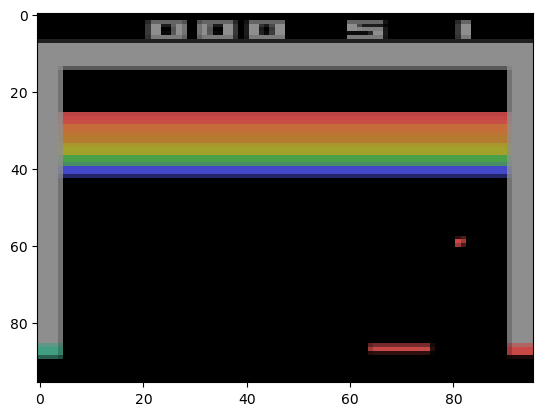

In [122]:
# See what the model learns

check_point_path = '/media/sc/datadisk/data/thinker/logs/breakout_v2/lm_reset_no_im/'
check_point_path = '/media/sc/datadisk/data/thinker/logs/breakout_v2/supervise_8'
#check_point_path = '/media/sc/datadisk/data/thinker/logs/breakout_v2/lm_no_im_no_enc/'
check_point_path = os.path.expanduser(check_point_path)
checkpoint = torch.load(os.path.join(check_point_path,'ckp_model.tar'), torch.device("cpu"))
flags = util.parse(['--load_checkpoint', check_point_path])

flags_ = copy.deepcopy(flags)
flags_.actor_see_p = 1
flags_.actor_see_encode = True
env = Environment(flags_, model_wrap=True)

env.seed([0])
num_actions = env.num_actions

flags_ = copy.deepcopy(flags)
flags_.perfect_model = True
flags_.actor_see_p = 1
perfect_env = Environment(flags_, model_wrap=True)
perfect_env.seed([0])

model_net = ModelNet(obs_shape=env.gym_env_out_shape, num_actions=env.num_actions, flags=flags)
model_net.train(False)
model_net.set_weights(checkpoint["model_state_dict"] if "model_state_dict" in 
                    checkpoint else checkpoint["model_net_state_dict"])  


env_out = env.initial(model_net)
perfect_env_out = perfect_env.initial(model_net)
util.decode_model_out(env_out.model_out, num_actions, True)    
plot_gym_env_out(env_out.gym_env_out.squeeze(0))

tensor([[False]]) tensor([[False]])


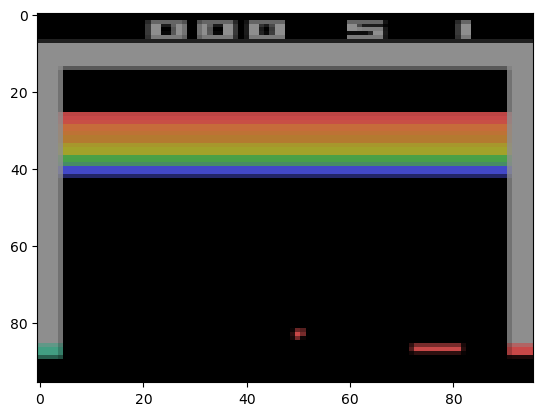

In [138]:
for _ in range(flags.rec_t):
    action = torch.tensor([[[0, 0, 0]]], dtype=torch.long)    
    env_out = env.step(action, model_net)
    perfect_env_out = perfect_env.step(action, model_net)
    if env_out.cur_t[0,0] == 0: break

print(env_out.done, env_out.real_done)    
plot_gym_env_out(env_out.gym_env_out.squeeze(0))
#util.decode_model_out(env_out.model_out, num_actions, True)

sparsity: 0.167969
sparsity: 0.182726
sparsity: 0.184896
sparsity: 0.189236
sparsity: 0.196181
sparsity: 0.201389
sparsity: 0.203776
sparsity: 0.192057
sparsity: 0.200955
sparsity: 0.215061
sparsity: 0.227214
sparsity: 0.238932
sparsity: 0.254557
sparsity: 0.262587
sparsity: 0.266276
sparsity: 0.275174
sparsity: 0.280816
sparsity: 0.288194
sparsity: 0.290365
sparsity: 0.292969


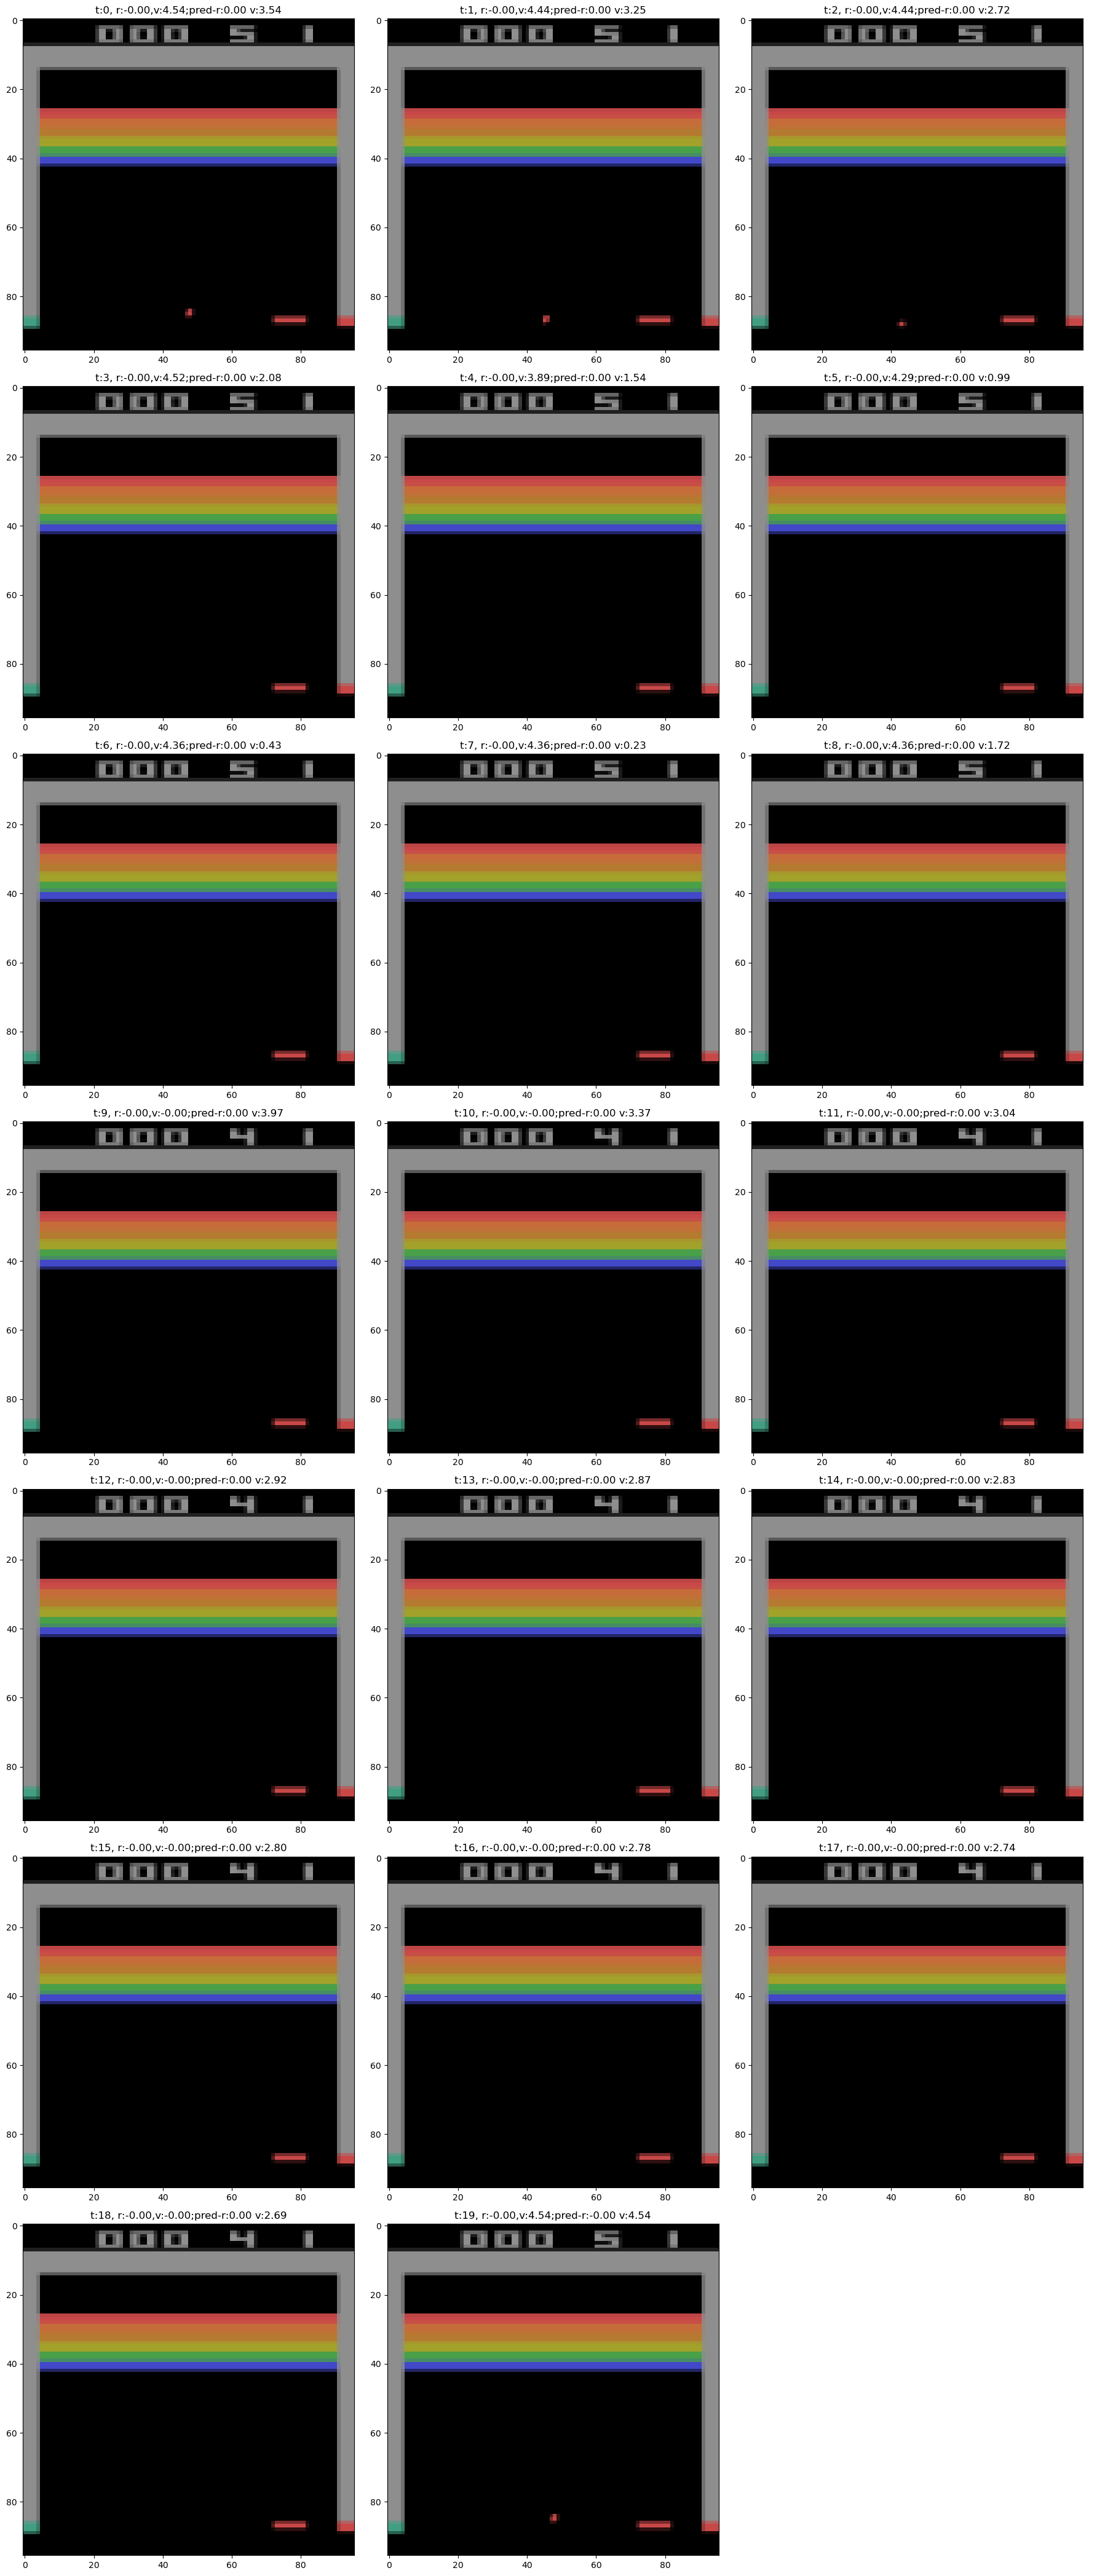

In [139]:
im_actions = [0 for _ in range(20)]
model_outs, perfect_model_outs = {}, {}
gym_env_outs = []

for im_action in im_actions:
    action = torch.tensor([[[0, im_action, 0]]], dtype=torch.long)
    env_out = env.step(action, model_net)
    perfect_env_out = perfect_env.step(action, model_net)

    model_out = util.decode_model_out(env_out.model_out, num_actions, True)
    print("sparsity: %4f" % (torch.sum(torch.abs(env_out.model_encodes) < 1e-4)/(torch.numel(env_out.model_encodes))))
    perfect_model_out = util.decode_model_out(perfect_env_out.model_out, num_actions, True)
    assert torch.all(model_out["root_logits"] == perfect_model_out["root_logits"])
    gym_env_outs.append(perfect_env_out.gym_env_out.squeeze(0).squeeze(0))

    for outs, out in [[model_outs, model_out], [perfect_model_outs, perfect_model_out]]:
        for k, v in out.items():
            if k not in outs:
                outs[k] = [v]
            else:
                outs[k].append(v)
    
titles = []
for n in range(len(model_outs["cur_r"])):
    titles.append("t:%d, r:%.2f,v:%.2f;pred-r:%.2f v:%.2f" % (
        n, perfect_model_outs["cur_r"][n],
        perfect_model_outs["cur_v"][n], model_outs["cur_r"][n], model_outs["cur_v"][n]))

fig = plot_multi_gym_env_out(gym_env_outs, titles=titles, col_n=3)
plt.show()

tensor([[7]])


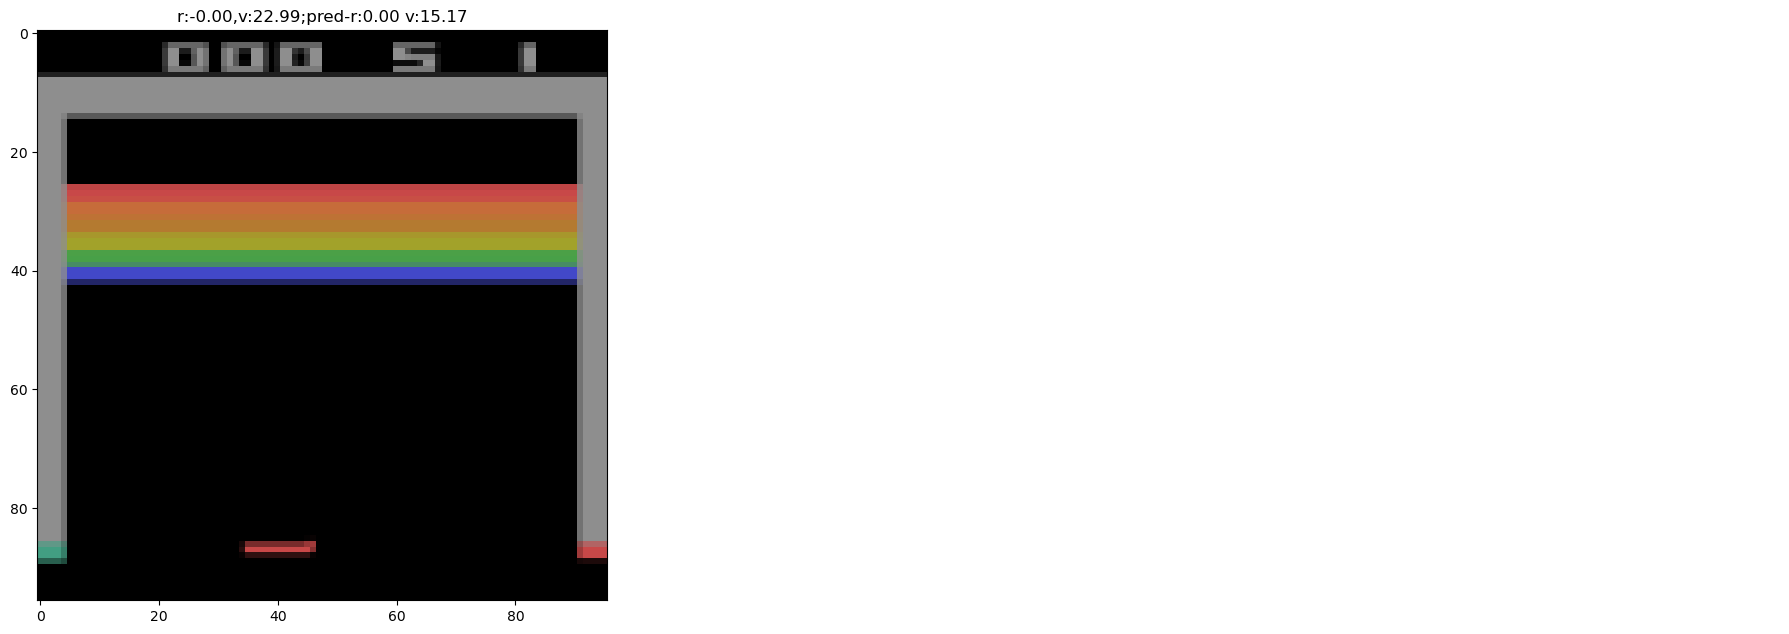

In [42]:
action = torch.tensor([[[0, 0, 1]]], dtype=torch.long)
env_out = env.step(action, model_net)
perfect_env_out = perfect_env.step(action, model_net)

model_out = util.decode_model_out(env_out.model_out, num_actions, flags.reward_transform)
perfect_model_out = util.decode_model_out(perfect_env_out.model_out, num_actions, flags.reward_transform)
assert torch.all(model_out["root_logits"] == perfect_model_out["root_logits"])

title = "r:%.2f,v:%.2f;pred-r:%.2f v:%.2f" % (perfect_model_out["cur_r"],
        perfect_model_out["cur_v"], model_out["cur_r"], model_out["cur_v"])

print(env_out.cur_t)
fig = plot_multi_gym_env_out([perfect_env_out.gym_env_out.squeeze(0).squeeze(0)], 
    titles=[title], col_n=3)
plt.show()


In [ ]:
# Visualize plain model policy

check_point_path = '~/RS/thinker/models/test'
check_point_path = os.path.expanduser(check_point_path)
max_eps_n = 100
visualize = False

flags = util.parse([])
env = Environment(flags, model_wrap=False)
env_out = env.initial()
model_net_rnn = ModelNet(obs_shape=env.gym_env_out_shape, num_actions=env.num_actions, flags=flags, rnn=True)
model_net_rnn.train(False)
checkpoint = torch.load(os.path.join(check_point_path,'ckp_model_rnn.tar'), torch.device("cpu"))                    
model_net_rnn.set_weights(checkpoint["model_state_dict"] if "model_state_dict" in 
                    checkpoint else checkpoint["model_net_state_dict"])  
state = model_net_rnn.core.init_state(bsz=1)

returns = []
step = 0
while len(returns) < max_eps_n:    
    step += 1
    _, model_rnn_logits, state = model_net_rnn(env_out.gym_env_out, env_out.last_action[:,:,0], env_out.done, state)
    action = torch.multinomial(F.softmax(model_rnn_logits[0], dim=1), num_samples=1).unsqueeze(0)
    env_out = env.step(action) 

    if visualize:
        fig, axs = plt.subplots(1, 2, figsize=(6,3))  
        plot_gym_env_out(env_out.gym_env_out[0], ax=axs[0], title="Step %d:v(s)=%.4f" % (step, vs[0]))
        plot_policies(model_rnn_logits[0,0], None, ax=axs[1])
        plt.show()

    if torch.any(env_out.done):
        step = 0
        new_rets = env_out.episode_return[env_out.done][:,0].numpy()
        returns.extend(new_rets)
        print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
            np.average(returns), np.std(returns) / np.sqrt(len(returns))))  


In [ ]:
# Visualize plain model policy

model_path = '/media/sc/datadisk/data/thinker/logs/planner_logs/thinker_model_no_pri/ckp_model.tar'
max_eps_n = 10
visualize = False

flags = util.parse([])
env = Environment(flags, model_wrap=False)
env_out = env.initial()
model_net = ModelNet(obs_shape=env.gym_env_out_shape, num_actions=env.num_actions, flags=flags)
model_net.train(False)
checkpoint = torch.load(model_path, torch.device("cpu"))
model_net.set_weights(checkpoint["model_state_dict"] if "model_state_dict" in 
                    checkpoint else checkpoint["model_net_state_dict"])  

returns = []
step = 0
while len(returns) < max_eps_n:    
    step += 1
    _, vs, policy_logits, _ = model_net(env_out.gym_env_out[0], env_out.last_action[:,:,0], one_hot=False)                            
    action = torch.multinomial(F.softmax(policy_logits[0], dim=1), num_samples=1).unsqueeze(0)
    env_out = env.step(action) 

    if visualize:
        fig, axs = plt.subplots(1, 2, figsize=(6,3))  
        plot_gym_env_out(env_out.gym_env_out[0], ax=axs[0], title="Step %d:v(s)=%.4f" % (step, vs[0]))
        plot_policies(policy_logits[0,0], None, ax=axs[1])
        plt.show()

    if torch.any(env_out.done):
        step = 0
        new_rets = env_out.episode_return[env_out.done][:,0].numpy()
        returns.extend(new_rets)
        print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
            np.average(returns), np.std(returns) / np.sqrt(len(returns))))  


<h5>Misc.</h5>

In [ ]:
from collections import namedtuple
import sys

import time
import numpy as np
import argparse
import ray
import torch

from thinker.self_play import SelfPlayWorker
from thinker.learn_actor import ActorLearner
from thinker.buffer import *
import thinker.util as util
from thinker.net import *

flags = util.parse([])
flags.model_batch_size = 2
flags.model_unroll_length = 8
flags.model_k_step_return = 5
flags.actor_parallel_n = 4
flags.model_buffer_n = 1000
flags.model_warm_up_n = 500
flags.model_batch_mode = True
flags.priority_alpha = 5

t = flags.model_unroll_length   
k = flags.model_k_step_return
n = flags.actor_parallel_n  

P = namedtuple("P", ["x","y"])
model_buffer = ModelBuffer(flags)

c = 0
for c in range(100):
    data = P(torch.full((t+k, n, 1),2*c), torch.full((t+k, n, 1),2*c+1))    
    model_buffer.write(data)
    r = model_buffer.read(1.)    
    if r is not None:
        data, weights, abs_flat_inds, ps_step = r
        #print(data.x[:,:,0]) 
        #model_buffer.update_priority(abs_flat_inds, np.zeros(flags.model_batch_size))

print("1 read", data.x[:,:,0], weights)
model_buffer.update_priority(abs_flat_inds, np.array([10, 0]))
data, weights, abs_flat_inds, ps_step = model_buffer.read(1.)   
print("2 read", data.x[:,:,0], weights)